In [1]:
import os, json, sys
sys.path.append('../..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

from density_lime.explanations.linear import ExplainLinear
from density_lime.explanations.visualization import ImagePlot
from density_lime.densities.density_vae import DensityVAE
from density_lime.densities.density_kde import DensityKDE
from density_lime.densities.density_kde_pca import DensityKDEKPCA, DensityKDEPCA

/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Loadind data and Model

In [3]:
import torch
import torch.utils.data
from torchvision import datasets, transforms

from playground.models import nmist_CNN

In [12]:
epochs = 10
cuda = torch.cuda.is_available()
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
device = torch.device("cuda" if cuda else "cpu")
device_cpu = torch.device("cpu")

# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('/media/tiagobotari/tiagobotari/data/MNIST1/', train=True, download=True,
#                    transform=transforms.ToTensor()),
#     batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/media/tiagobotari/tiagobotari/data/', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

In [14]:
path='mode_nmist_cnn.pth'
model = nmist_CNN.model_load(device, path=path)
def model_predict(x_):
    if isinstance(x_, torch.Tensor):
        x_tf = x_
    else:
        x_tf = torch.from_numpy(x_)
    with torch.no_grad():
        x_tf = x_tf.reshape(-1, 1, 28, 28)
        y = model(x_tf.to(device=device))
        y = y.data.exp().to(device_cpu).numpy()
        return y

In [15]:
examples = enumerate(test_loader)

In [16]:

batch_idx, (example_data, example_targets) = next(examples)

In [17]:
x_examples = example_data #.to(density.model.device_cpu).numpy()
x_examples.shape

torch.Size([128, 1, 28, 28])

In [18]:
def plot_instances(ax, x_, y_=None):
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.set_title(y_)
    return ax.imshow(x_, interpolation = 'none')

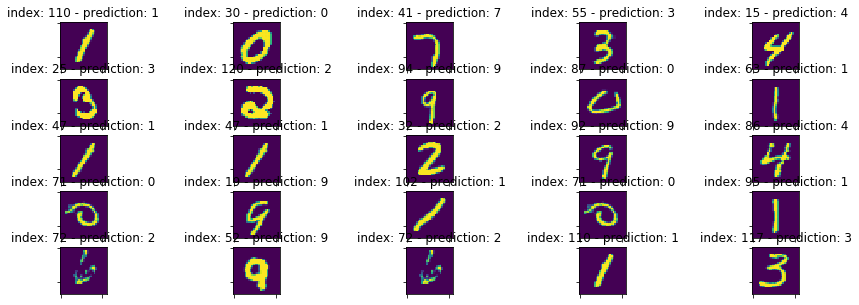

In [19]:
fig, axis = plt.subplots(5,5, figsize=(15, 5))
axis = axis.reshape(-1)
for ax in axis:
     index = np.random.choice(range(125))
     x_explain = x_examples[index][0]
     with torch.no_grad():
         y = model_predict(x_explain.view(-1, 1, 28, 28))
         y = 'index: {:} - prediction: {:}'.format(index, np.argmax(y))
     cp = plot_instances(ax, x_explain, y)

In [20]:
# fig, axis = plt.subplots(25,5, figsize=(15, 40))
# axis = axis.reshape(-1)
# for ax, index in zip(axis, range(125)):
#     x_explain = x_examples[index][0]
#     with torch.no_grad():
#         y = model_predict(x_explain.view(-1, 1, 28, 28))
#         y = 'index: {:} - prediction: {:}'.format(index, np.argmax(y))
#     cp = plot_instances(ax, x_explain, y)

### Explain a instance

predicted: 3
top 3 predicted Class [3 8 9]


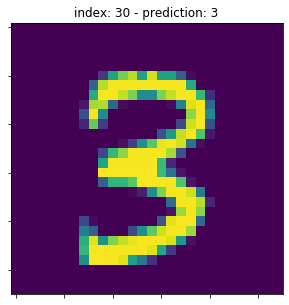

In [58]:
index = 30
# x_explain = x_examples[index][0].to(device_cpu).numpy()
# np.savetxt('three_explain.np', x_explain)
x_explain = np.loadtxt('three_explain.np').astype(np.float32)
y_explain = model_predict(x_explain)
y_explain_index = np.argmax(y_explain)

print('predicted:', y_explain_index)
top_three = np.argsort(y_explain)[0][::-1]
print('top 3 predicted Class', top_three[:3])
fig, axis = plt.subplots(1, figsize=(15, 5))
y = 'index: {:} - prediction: {:}'.format(index, np.argmax(y_explain))
cp = plot_instances(axis, x_explain, y)


## DensityVAE

In [59]:
density = DensityVAE(input_dim=784)

In [60]:
# density.fit(train_loader, epochs=20)

In [61]:
# density.save_manifold('./mode_vae_manifold.pth')

In [62]:
density = density.load_manifold('./mode_vae_manifold.pth')

In [64]:
if False:
    x_sample = density.sample_radius(x_exp=x_explain.reshape(-1, 784), r=1.5, n_samples=15000, random_state=None)
    fig, axis = plt.subplots(5, 10, figsize=(15, 5))
    axis= axis.reshape(-1)
    for ax, img_i in zip(axis, x_sample[:50]):
        x_ = img_i.reshape(28, 28)
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.imshow(x_, interpolation = 'none')
    plt.subplots_adjust(left=0.01, bottom=0.01, right=0.99, top=0.99, wspace=0.01, hspace=0.001)
    plt.show()

## Explantion for the top 3 Classes

Explanation for  3


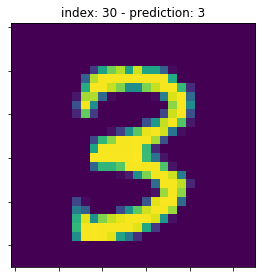

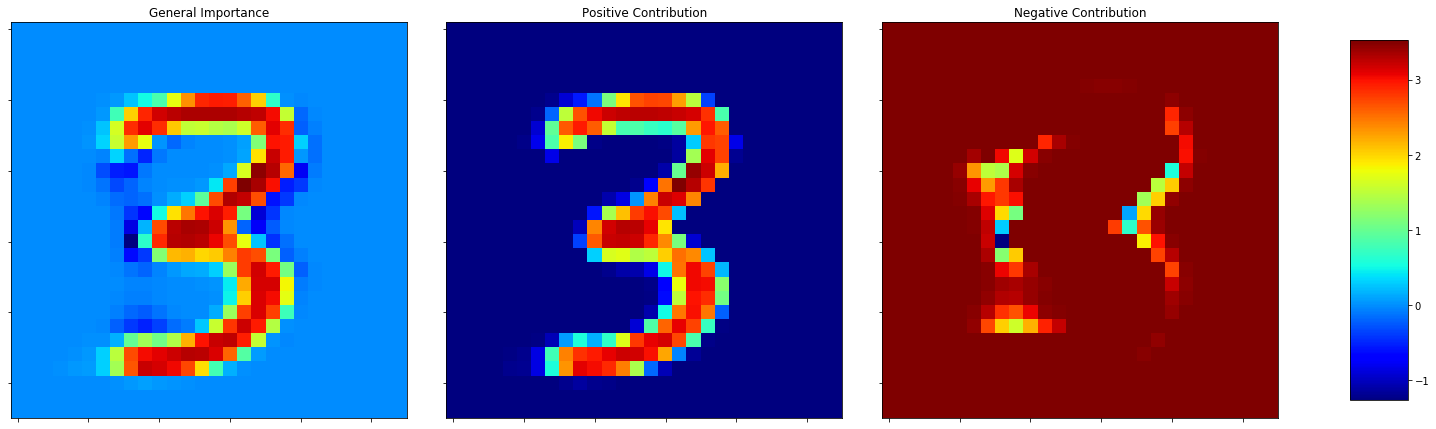

In [66]:
torch.cuda.empty_cache()
class_to_explain = top_three[0]
print('Explanation for ', class_to_explain)
try:
    del explain_linear
except:
    pass
explain_linear = ExplainLinear(
    model_predict=model_predict, density=density, linear_model='SGD', verbose=False)
result = explain_linear.explain_instance(
    x_explain=x_explain
    , r=0.1, class_index=class_to_explain, tol=0.05)
y = 'index: {:} - prediction: {:}'.format(index, np.argmax(y_explain))
fig, axis = plt.subplots(1, figsize=(4.5, 4.5))
ax = plot_instances(axis, x_explain, y)
a = ImagePlot.plot_importance(result['importance'], standardization=True)


Explanation for  8


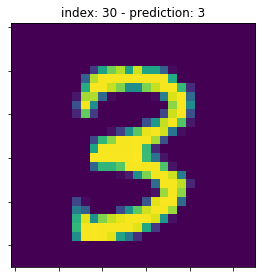

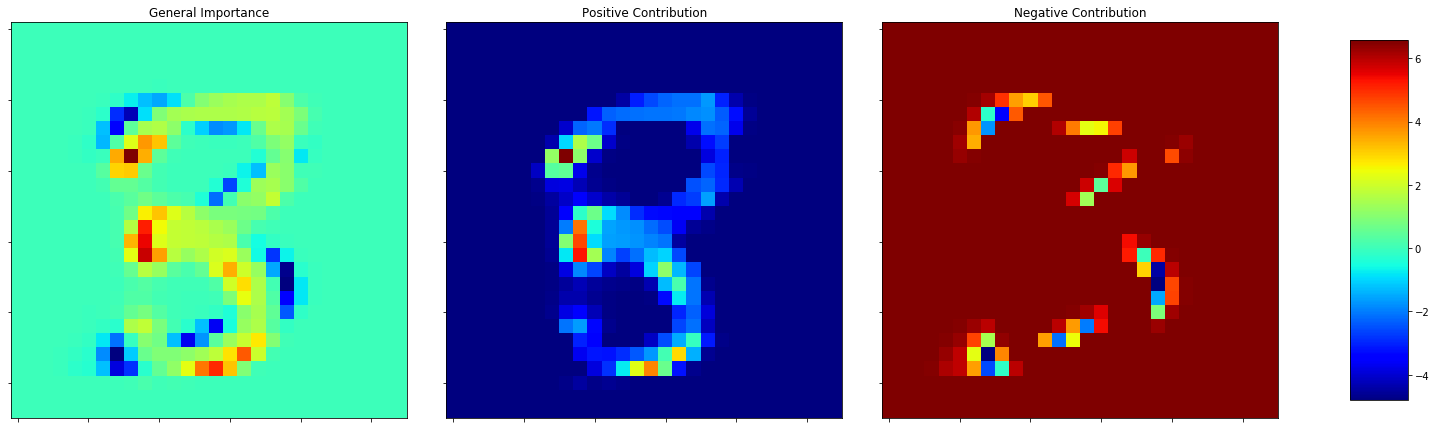

In [67]:
torch.cuda.empty_cache()
class_to_explain = top_three[1]
print('Explanation for ', class_to_explain)
explain_linear = ExplainLinear(
    model_predict=model_predict, density=density, linear_model='SGD', verbose=False)
result = explain_linear.explain_instance(
    x_explain=x_explain
    , r=0.1, class_index=class_to_explain, tol=0.05)
y = 'index: {:} - prediction: {:}'.format(index, np.argmax(y_explain))
fig, axis = plt.subplots(1, figsize=(4.5, 4.5))
ax = plot_instances(axis, x_explain, y)
a = ImagePlot.plot_importance(result['importance'], standardization=True)

Explanation for  9


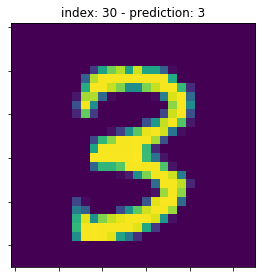

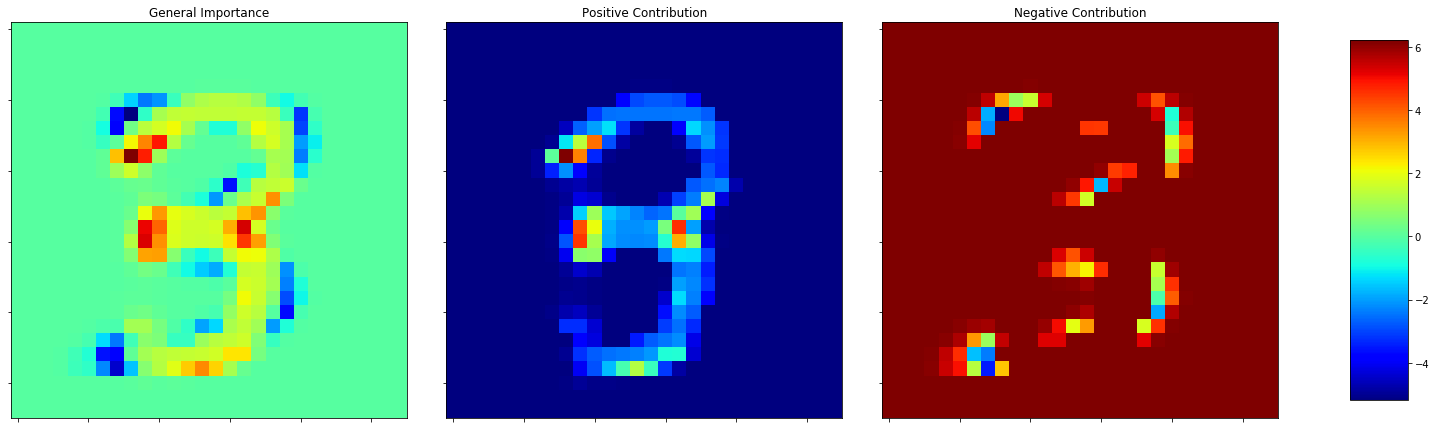

In [68]:
torch.cuda.empty_cache()
class_to_explain = top_three[2]
print('Explanation for ', class_to_explain)
explain_linear = ExplainLinear(
    model_predict=model_predict, density=density, linear_model='SGD', verbose=False)
result = explain_linear.explain_instance(
    x_explain=x_explain
    , r=0.1, class_index=class_to_explain, tol=0.05)
y = 'index: {:} - prediction: {:}'.format(index, np.argmax(y_explain))
fig, axis = plt.subplots(1, figsize=(4.5, 4.5))
ax = plot_instances(axis, x_explain, y)
a = ImagePlot.plot_importance(result['importance'], standardization=True)

# Explain number 5

predicted: 5
top 3 predicted Class [5 3 6]


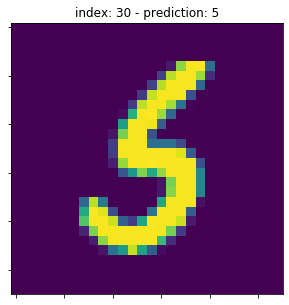

In [69]:
x_explain = np.loadtxt('five_explain.np').astype(np.float32)
y_explain = model_predict(x_explain)
y_explain_index = np.argmax(y_explain)

print('predicted:', y_explain_index)
top_three = np.argsort(y_explain)[0][::-1]
print('top 3 predicted Class', top_three[:3])
if y_explain_index ==5:
    fig, axis = plt.subplots(1, figsize=(15, 5))
    y = 'index: {:} - prediction: {:}'.format(index, np.argmax(y_explain))
    cp = plot_instances(axis, x_explain, y)


Explanation for  5


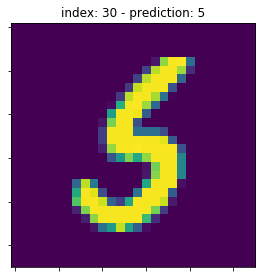

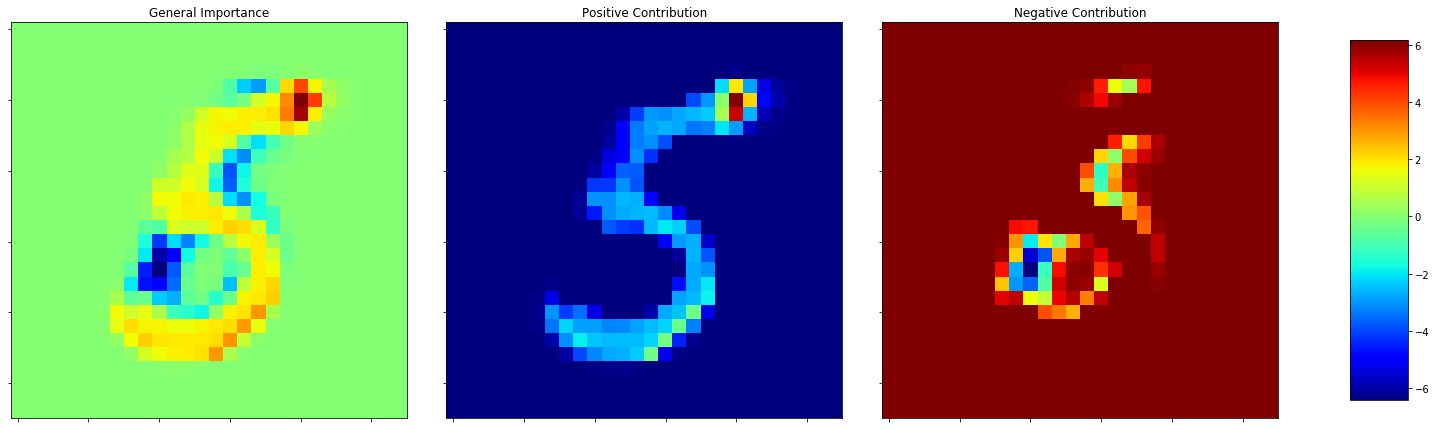

In [71]:
torch.cuda.empty_cache()
class_to_explain = top_three[0]
print('Explanation for ', class_to_explain)
explain_linear = ExplainLinear(model_predict=model_predict, density=density, linear_model='SGD', verbose=False)
result = explain_linear.explain_instance(
    x_explain=x_explain
    , r=0.1, class_index=class_to_explain, tol=0.05)
y = 'index: {:} - prediction: {:}'.format(index, np.argmax(y_explain))
fig, axis = plt.subplots(1, figsize=(4.5, 4.5))
ax = plot_instances(axis, x_explain, y)
a = ImagePlot.plot_importance(result['importance'], standardization=True)

Explanation for  3


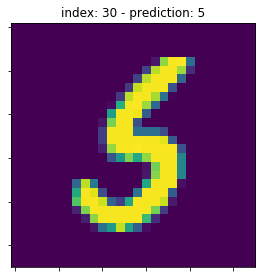

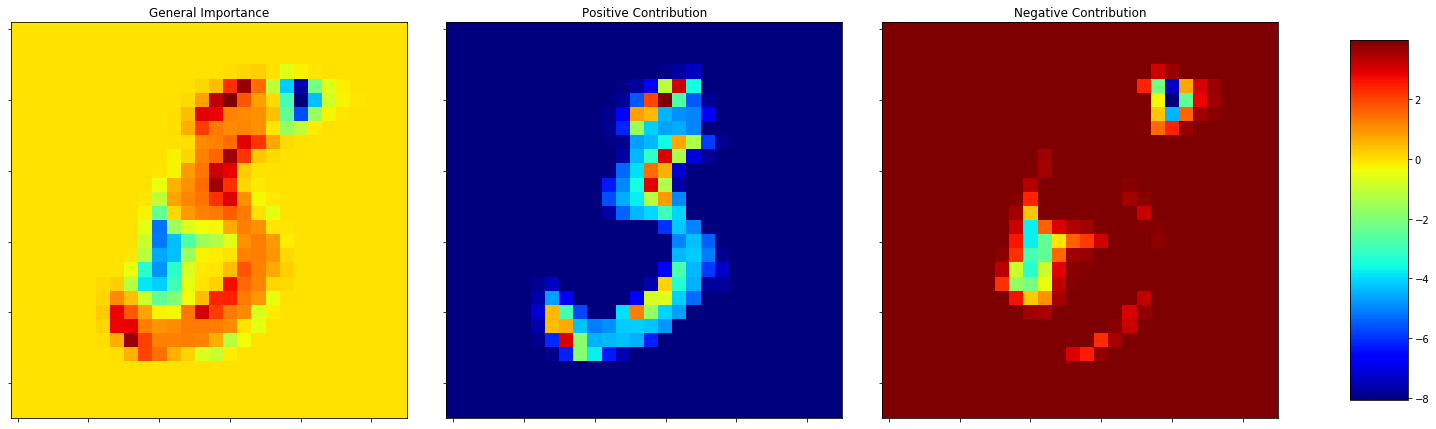

In [74]:
torch.cuda.empty_cache()
class_to_explain = top_three[1]
print('Explanation for ', class_to_explain)
explain_linear = ExplainLinear(model_predict=model_predict, density=density, linear_model='SGD', verbose=False)
result = explain_linear.explain_instance(
    x_explain=x_explain
    , r=0.1, class_index=class_to_explain, tol=0.05)
y = 'index: {:} - prediction: {:}'.format(index, np.argmax(y_explain))
fig, axis = plt.subplots(1, figsize=(4.5, 4.5))
ax = plot_instances(axis, x_explain, y)
a = ImagePlot.plot_importance(result['importance'], standardization=True)

Explanation for  6


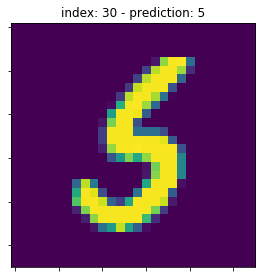

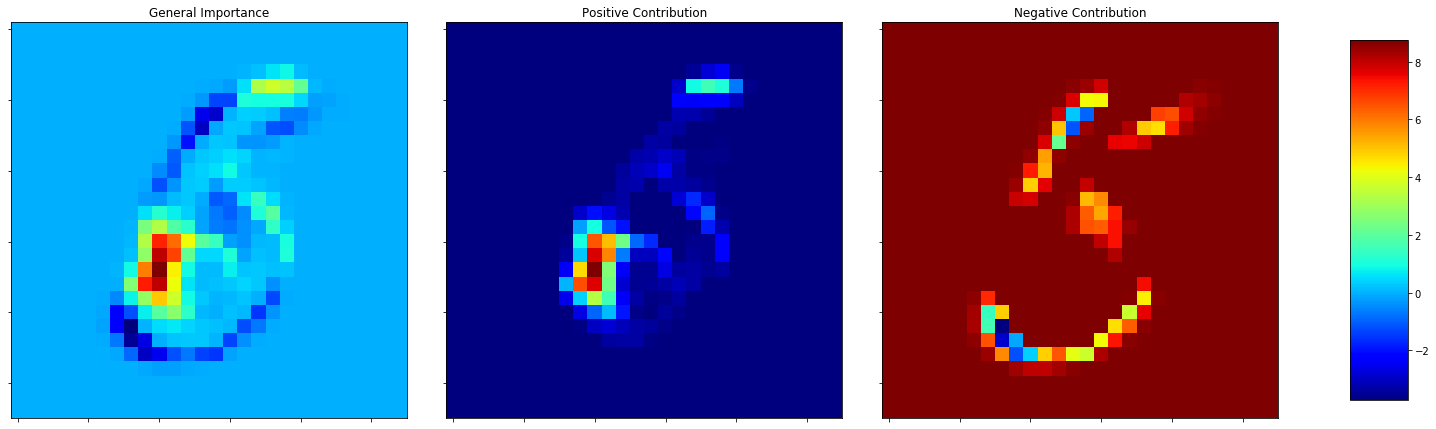

In [75]:
torch.cuda.empty_cache()
class_to_explain = top_three[2]
print('Explanation for ', class_to_explain)
explain_linear = ExplainLinear(model_predict=model_predict, density=density, linear_model='SGD', verbose=False)
result = explain_linear.explain_instance(
    x_explain=x_explain
    , r=0.1, class_index=class_to_explain, tol=0.05)
y = 'index: {:} - prediction: {:}'.format(index, np.argmax(y_explain))
fig, axis = plt.subplots(1, figsize=(4.5, 4.5))
ax = plot_instances(axis, x_explain, y)
a = ImagePlot.plot_importance(result['importance'], standardization=True)

In [76]:
torch.cuda.empty_cache()
class_to_explain = top_three[0]
print('Explanation for ', class_to_explain)
explain_linear = ExplainLinear(model_predict=model_predict, density=density, linear_model='HuberRegressor', verbose=False)
result = explain_linear.explain_instance(
    x_explain=x_explain
    , r=0.1, class_index=class_to_explain, tol=0.05)
y = 'index: {:} - prediction: {:}'.format(index, np.argmax(y_explain))
fig, axis = plt.subplots(1, figsize=(4.5, 4.5))
ax = plot_instances(axis, x_explain, y)
a = ImagePlot.plot_importance(result['importance'], standardization=True)

Explanation for  5


/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs faile

/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs faile

/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs faile

/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs faile

/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs faile

/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs faile

/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs faile

/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs faile

/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs faile

/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs faile

/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs faile

/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tiagobotari/anaconda3/envs/density-lime3.7/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs faile

KeyboardInterrupt: 